In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from matplotlib import style, offsetbox
import matplotlib.cm as cm
style.use('ggplot') or plt.style.use('ggplot')
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram

import sklearn.feature_selection as featsel
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

from ipywidgets import interact, widgets


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
path = '/Users/sbk/Documents/GitHub/Barryjuait/Personal Projects/files/DyskDataset.csv'
data= pd.read_csv(path)

#select only right hemi:
#data.dropna(subset = 'AIMS', inplace=True);
data = data[data.Hemi == 'R'].reset_index(drop=True);
X_data = data.drop(['RecID', 'ID', 'Hemi', 'Rat', 'Drug', 'taxis', 'AIMS', 'Acc'], axis=1)
cols = list(X_data.columns);
Drug = data.Drug.astype('category');
Aims = data.AIMS;
taxis = data.taxis.astype('float');
RecID = data.RecID.astype('category'); 

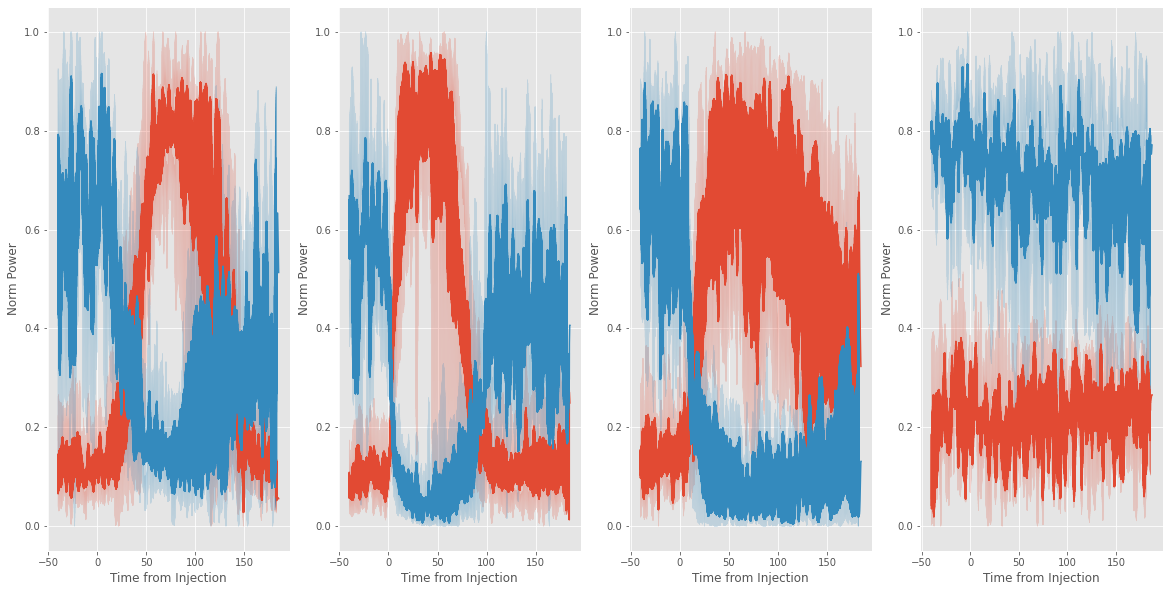

In [6]:
fig, ax = plt.subplots(1,4,figsize = (20,10))
bDrugs = np.unique(Drug);
for ix in range(len(bDrugs)):
    sns.lineplot(data=data[Drug == bDrugs[ix]], x="taxis", y="NBG", ax = ax[ix]);
    sns.lineplot(data=data[Drug == bDrugs[ix]], x="taxis", y="Beta", ax = ax[ix]);
    ax[ix].set_xlabel('Time from Injection');
    ax[ix].set_ylabel('Norm Power');
plt.show();    

In [8]:
X_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Delta,221695.0,0.281068,0.138161,0.0,0.187430,0.268752,0.351407,1.000000
Theta,221695.0,0.447693,0.246043,0.0,0.238174,0.417730,0.647015,1.000000
Beta,221695.0,0.362379,0.292163,0.0,0.098084,0.286329,0.622607,1.000000
BBG,221695.0,0.286812,0.200889,0.0,0.141580,0.250667,0.379831,1.000000
NBG,221695.0,0.357854,0.294990,0.0,0.114593,0.250152,0.589196,1.000000
BGRatio,221695.0,1.073712,0.379777,0.5,0.703235,1.078145,1.399278,1.985032
stdDelta,221695.0,0.079664,0.036306,0.0,0.053618,0.075115,0.096529,0.303253
stdTheta,221695.0,0.121621,0.068674,0.0,0.067637,0.101386,0.164177,0.347726
stdBeta,221695.0,0.115872,0.074188,0.0,0.053730,0.102475,0.168970,0.368770
stdBBG,221695.0,0.090107,0.053174,0.0,0.055692,0.078582,0.105870,0.395194


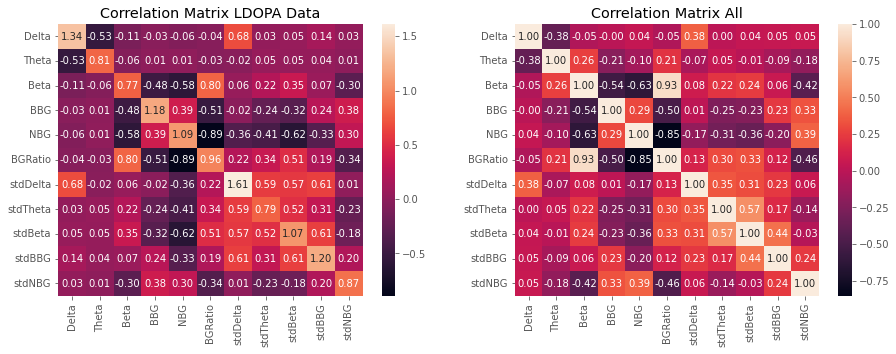

In [11]:
from sklearn.preprocessing import StandardScaler
dummy = X_data.copy();
normX = StandardScaler().fit_transform(dummy);

LDX =  normX[Drug == 'VEH+L-DOPA'];
dfLD = pd.DataFrame(LDX, columns = cols);

fig, ax = plt.subplots(1,2,figsize = (15,5))
c_matrix = pd.DataFrame.cov(dfLD)
sns.heatmap(c_matrix, annot=True, fmt='.2f', ax = ax[0]);
ax[0].set_title('Correlation Matrix LDOPA Data')

df = pd.DataFrame(normX, columns = cols);
c_matrix = pd.DataFrame.cov(df)
sns.heatmap(c_matrix, annot=True, fmt='.2f', ax = ax[1]);
ax[1].set_title('Correlation Matrix All')
plt.show()

dfLD['Drug'] = Drug[Drug == 'VEH+L-DOPA'];
dfLD['AIMS'] = Aims[Drug == 'VEH+L-DOPA'];
dfLD['taxis'] = taxis[Drug == 'VEH+L-DOPA'];
dfLD['RecID'] = RecID[Drug == 'VEH+L-DOPA'];

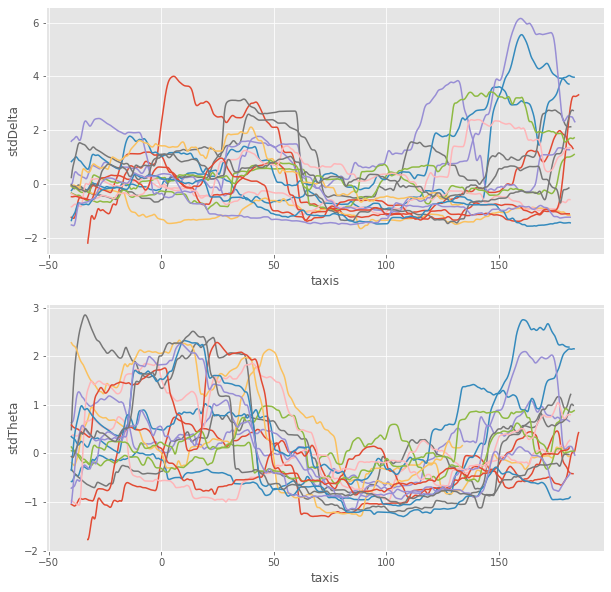

In [12]:
fig, ax = plt.subplots(2,1,figsize = (10,10))

recs = np.unique(RecID);
for ix in range(len(recs)):
    sns.lineplot(data=dfLD[RecID == recs[ix]], x="taxis", y="stdDelta", ax = ax[0])
    sns.lineplot(data=dfLD[RecID == recs[ix]], x="taxis", y="stdTheta", ax = ax[1])

plt.show();    




In [13]:
#Using silouhette method to find optimum number of clusters:
range_n_clusters = range(2, 8)
avg_silhouette = []

for n_clusters in range_n_clusters:
    print(f'-- calculating silhouette score for {n_clusters} clusters')
    model = AgglomerativeClustering(
                    affinity   = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters,
                    compute_distances = True)

    cluster_labels = model.fit_predict(LDX)
    silhouette_avg = silhouette_score(LDX, cluster_labels)
    avg_silhouette.append(silhouette_avg)


bNClus = np.array(list(range_n_clusters));

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(bNClus, avg_silhouette, marker='o')
ax.set_title("Silhouette Index Evolution")
ax.set_xlabel('# Clusters')
ax.set_ylabel('Average Silhouette Score');

In [7]:
sel = avg_silhouette == max(avg_silhouette);
n_clus = bNClus[sel][0];
print(f'\n The optimum number of clusters is {n_clus}');


 The optimum number of clusters is 2


In [8]:
n_clus = 4

In [9]:
model_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            n_clusters         = n_clus,
                            compute_distances = True);
model_hclust_complete.fit(X = LDX);


model_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            n_clusters         = n_clus,
                            compute_distances = True);
model_hclust_average.fit(X = LDX);

model_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters = n_clus,
                            compute_distances = True);
model_hclust_ward.fit(X = LDX);

In [10]:
def plot_dendrogram(model, **kwargs):
    '''
    This function extracts information from an AgglomerativeClustering model and represents its dendrogram with the function
    dendogram from scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    d = dendrogram(linkage_matrix, truncate_mode = 'level', p = 5, **kwargs) #display only 5 levels
    return d

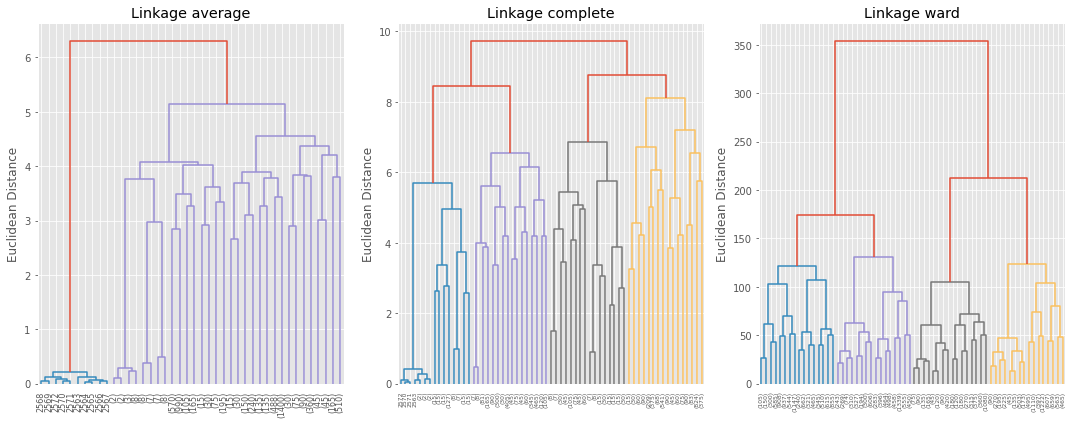

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

plot_dendrogram(model_hclust_average, color_threshold = 6, ax = ax[0])
ax[0].set_title("Linkage average")
ax[0].set_ylabel('Euclidean Distance');

plot_dendrogram(model_hclust_complete, color_threshold = 8.2, ax =ax[1])
ax[1].set_title("Linkage complete")
ax[1].set_ylabel('Euclidean Distance');

plot_dendrogram(model_hclust_ward, color_threshold = 140, ax = ax[2])
ax[2].set_title("Linkage ward")
ax[2].set_ylabel('Euclidean Distance');

plt.tight_layout();

In [28]:
y = model_hclust_ward.fit_predict(LDX);

In [56]:
dfLD['Stage'] = y;

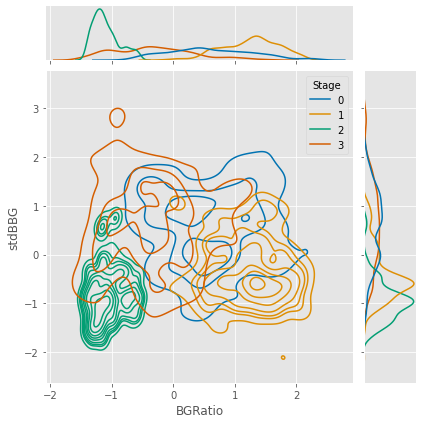

In [59]:
sns.jointplot(data = dfLD, x = 'BGRatio', y = 'stdBBG', hue  = 'Stage', palette='colorblind', cmap='RdBu', kind = 'kde');

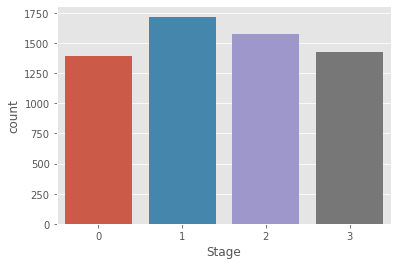

In [39]:
sns.countplot(x = 'Stage', data = dfLD);

In [41]:
#Features Selection:

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
# Importamos ExhaustiveFeatureSelector desde Mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# Creamos la instancia del clasificador logistic regression 
lr = LogisticRegression()

# Creamos la instancia EFS 
efs = EFS(estimator=lr,        # Utilice la regresión logística como clasificador/estimador
          min_features=1,      # Número mínimo de características a considerar: 1
          max_features=6,      # Número máximo de características a considerar: 4
          scoring='accuracy',  # Métrica a utilizar para evaluar el clasificador
          cv=2)                # Nuúmero de cross-validations a ejecutar: 5


# Entrenamos EFS 
efs = efs.fit(LDX, y)

# Imprimimos resultados
print(f'\nBest accuracy score: {efs.best_score_:4.2f}') # best_score_  muestra el mejor score 
print(f'Best subset (indices): {efs.best_idx_}') # best_idx_  muestra los índices de las 
                                                  # caractarísticas que entregan el mejor score
print(f'Best subset (names): {efs.best_feature_names_}') # best_feature_names_  
                                                            # muestra los nombres de las caractarísticas
                                                            # que entregan el mejor score


Features: 1485/1485


Best accuracy score: 0.85
Best subset (indices): (1, 3, 5, 8, 9, 10)
Best subset (names): ('1', '3', '5', '8', '9', '10')


In [42]:
X_data_new = efs.transform(LDX)

# Veamos el desempeño de cada subconjunto de características
efs_results = pd.DataFrame.from_dict(efs.get_metric_dict()).T
efs_results.sort_values(by='avg_score', ascending=True, inplace=True)
efs_results

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
0,"(0,)","[0.2793588485443245, 0.22087696335078533]",0.250118,"(0,)",0.125814,0.029241,0.029241
11,"(0, 1)","[0.27118089630356557, 0.30137434554973824]",0.286278,"(0, 1)",0.064956,0.015097,0.015097
1,"(1,)","[0.31436048413477263, 0.32100785340314136]",0.317684,"(1,)",0.014301,0.003324,0.003324
6,"(6,)","[0.3810925744193654, 0.4083769633507853]",0.394735,"(6,)",0.058698,0.013642,0.013642
25,"(1, 6)","[0.3941772980045797, 0.39986910994764396]",0.397023,"(1, 6)",0.012245,0.002846,0.002846
...,...,...,...,...,...,...,...
1371,"(1, 3, 5, 7, 8, 9)","[0.8485443245011449, 0.8337696335078534]",0.841157,"(1, 3, 5, 7, 8, 9)",0.031785,0.007387,0.007387
1272,"(0, 5, 6, 8, 9, 10)","[0.8554138043833824, 0.8278795811518325]",0.841647,"(0, 5, 6, 8, 9, 10)",0.059235,0.013767,0.013767
1373,"(1, 3, 5, 7, 9, 10)","[0.8593392214589467, 0.8370418848167539]",0.848191,"(1, 3, 5, 7, 9, 10)",0.047969,0.011149,0.011149
1475,"(3, 5, 6, 8, 9, 10)","[0.8560680405626431, 0.8432591623036649]",0.849664,"(3, 5, 6, 8, 9, 10)",0.027556,0.006404,0.006404


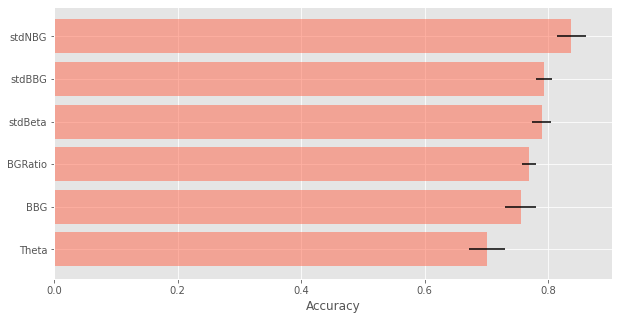

In [43]:
import random

#get features names:
idx = list(efs.best_idx_);
y_label = [];
for ix in range(len(idx)):
    y_label.append(cols[idx[ix]])
    
#plot:    
i = random.choices(range(0, len(efs_results)-1), k=X_data_new.shape[1])
i.sort()
fig, ax = plt.subplots(figsize=(10,5))
y_pos = range(len(i)) # len(efs_results)) si quiere visualizarlos todos
ax.barh(y_pos, 
        efs_results.iloc[i]['avg_score'],
        xerr=efs_results.iloc[i]['std_dev'],
        color='tomato',
        alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
#ax.set_yticklabels([]) #efs_results['feature_names']) si quiere ver los nombres
ax.set_xlabel('Accuracy')
plt.show()

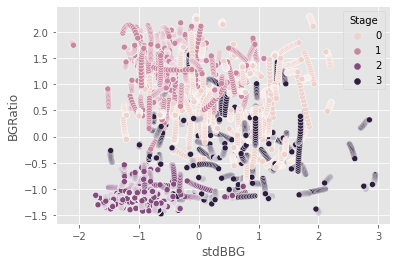

In [48]:
sns.scatterplot(data = dfLD, x = 'stdBBG', y = 'BGRatio', hue = 'Stage');

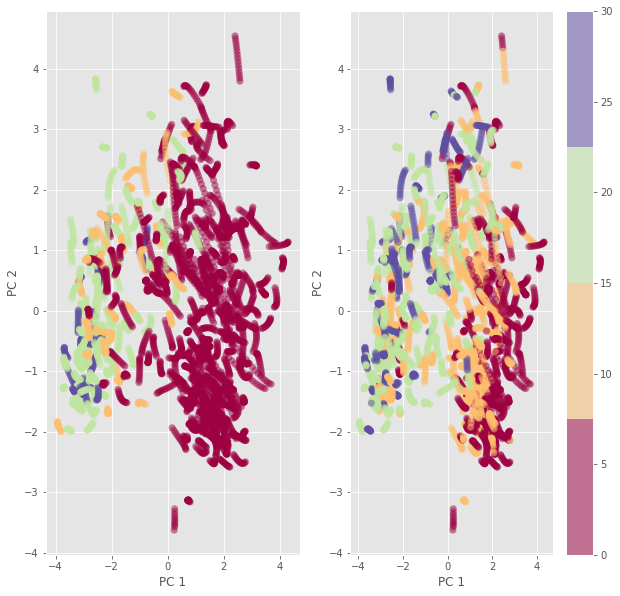

In [52]:
from sklearn.decomposition import PCA

fig,ax = plt.subplots(1,2, figsize = (10,10))
#ax = fig.add_subplot(projection='3d')

pca = PCA(3)
projected = pca.fit_transform(LDX);

sc = ax[0].scatter(projected[:, 0], projected[:, 1],
            c=dfLD.AIMS, edgecolor='none', s = 50, alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 4))
ax[0].set_xlabel('PC 1');
ax[0].set_ylabel('PC 2');
#ax.set_zlabel('PC 3');
fig.colorbar(sc)

sc = ax[1].scatter(projected[:, 0], projected[:, 1],
            c=dfLD.BBG, edgecolor='none', s = 50, alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 4))
ax[1].set_xlabel('PC 1');
ax[1].set_ylabel('PC 2');
plt.show();


